In [1]:
import utils.tutorial_analysis_classes
import utils.tutorial_utils

## Initial estimates

In [2]:
estimate_f_resonator = dict(
    Q1 = 5.72035 * 1e9,
    Q2 = 6.0085 * 1e9,
    Q3 = 5.83875 * 1e9,
    Q4 = 6.1073 * 1e9,
    Q5 = 5.9139 * 1e9,
)
estimate_f_qubits = dict(
    Q1 = 4.116883353122914 * 1e9,
    Q2 = 4.232816338702908 * 1e9,
    Q3 = 3.8418045414828643 * 1e9,
    Q4 = 4.022 * 1e9,
    Q5 = 2.5738611635902258 * 1e9,
)

In [3]:
for k, v in estimate_f_resonator.items():
    print(((v - 5.9e9))/1e6)

-179.65
108.5
-61.25
207.3
13.9


## Configuration file

In [4]:
HARDWARE_CONFIG = {
    'backend': 'quantify_scheduler.backends.qblox_backend.hardware_compile',
    'cluster0': {
        'sequence_to_file': False,
        'ref': 'internal',
        'instrument_type': 'Cluster',
        # === DRIVE === #
        'cluster0_module4': {
            'instrument_type': 'QCM_RF',
            'complex_output_0': { 'portclock_configs': [ {'port': 'Q1:mw', 'clock': 'Q1.01', "interm_freq" : 80e6} ] },
            'complex_output_1': { 'portclock_configs': [ {'port': 'Q2:mw', 'clock': 'Q2.01', "interm_freq" : 80e6} ] }
        },
        'cluster0_module6': {
            'instrument_type': 'QCM_RF',
            'complex_output_0': { 'portclock_configs': [ {'port': 'Q3:mw', 'clock': 'Q3.01', "interm_freq" : 80e6} ] },
            'complex_output_1': { 'portclock_configs': [ {'port': 'Q4:mw', 'clock': 'Q4.01', "interm_freq" : 80e6} ] }
        },
        'cluster0_module12': {
            'instrument_type': 'QCM_RF',
            'complex_output_0': { 'portclock_configs': [ {'port': 'Q5:mw', 'clock': 'Q5.01', "interm_freq" : 80e6} ] },
        },
        # === FLUX === #
        'cluster0_module2': {
            'instrument_type': 'QCM',
            'real_output_0': {'portclock_configs': [{'port': 'Q1:fl', 'clock': 'cl0.baseband'}]},
            'real_output_1': {'portclock_configs': [{'port': 'Q2:fl', 'clock': 'cl0.baseband'}]},
            'real_output_2': {'portclock_configs': [{'port': 'Q3:fl', 'clock': 'cl0.baseband'}]},
            'real_output_3': {'portclock_configs': [{'port': 'Q4:fl', 'clock': 'cl0.baseband'}]}
        },
        'cluster0_module10': {
            'instrument_type': 'QCM',
            'real_output_0': {'portclock_configs': [{'port': 'Q5:fl', 'clock': 'cl0.baseband'}]},
        },
        # === READOUT === #
        'cluster0_module8': {
            'instrument_type': 'QRM_RF',
            'complex_output_0': {
                'lo_freq': 5.9e9,
                'portclock_configs': [
                    {'port': 'Q1:res', 'clock': 'Q1.ro'},
                    {'port': 'Q2:res', 'clock': 'Q2.ro'},
                    {'port': 'Q3:res', 'clock': 'Q3.ro'},
                    {'port': 'Q4:res', 'clock': 'Q4.ro'},
                    {'port': 'Q5:res', 'clock': 'Q5.ro'},
                ],
            }
        }
    }
}

In [5]:
from qblox_instruments import Cluster
cluster = Cluster(name="cluster0", identifier="192.168.1.170")

## Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters and repeats startup calibration, so resetting between experiments is usually not desirable.

In [6]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


## Quantum device settings
Here we initialize our `QuantumDevice` and our qubit parameters,  checkout this [tutorial](https://quantify-quantify-scheduler.readthedocs-hosted.com/en/latest/tutorials/Operations%20and%20Qubits.html) for further details.

In short, a `QuantumDevice` contains device elements where we save our found parameters.

In [7]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

def create_quantum_device(num_qubits : int) -> QuantumDevice:
    quantum_device = QuantumDevice("academia_sinica_device")
    quantum_device.hardware_config(HARDWARE_CONFIG)
    
    # store references
    quantum_device._device_elements = list()

    for i in range(1,num_qubits + 1):
        qubit = BasicTransmonElement(f"Q{i}")
        qubit.measure.acq_channel(i)
        quantum_device.add_element(qubit)
        quantum_device._device_elements.append(qubit)
    
    return quantum_device

quantum_device = create_quantum_device(5)

## Configure measurement control loop
We will use a `MeasurementControl` object for data acquisition as well as an `InstrumentCoordinator` for controlling the instruments in our setup.

The `PlotMonitor` is used for live plotting.

All of these are then associated with the `QuantumDevice`.

In [8]:
from quantify_core.measurement.control import MeasurementControl
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt as PlotMonitor
from qcodes import Instrument

def configure_measurement_control_loop(
    device: QuantumDevice, cluster: Cluster, live_plotting: bool = False
) -> None:
    # Close QCoDeS instruments with conflicting names
    for name in [
        "PlotMonitor",
        "meas_ctrl",
        "ic",
        "ic_generic",
        f"ic_{cluster.name}",
    ] + [f"ic_{module.name}" for module in cluster.modules]:
        try:
            Instrument.find_instrument(name).close()
        except KeyError:
            pass

    meas_ctrl = MeasurementControl("meas_ctrl")
    ic = InstrumentCoordinator("ic")

    # Add cluster to instrument coordinator
    ic_cluster = ClusterComponent(cluster)
    ic.add_component(ic_cluster)

    if live_plotting:
        # Associate plot monitor with measurement controller
        plotmon = PlotMonitor("PlotMonitor")
        meas_ctrl.instr_plotmon(plotmon.name)

    # Associate measurement controller and instrument coordinator with the quantum device
    device.instr_measurement_control(meas_ctrl.name)
    device.instr_instrument_coordinator(ic.name)

    return (meas_ctrl, ic)


meas_ctrl, instrument_coordinator = configure_measurement_control_loop(quantum_device, cluster)

## Set data directory
This directory is where all of the experimental data as well as all of the post processing will go.

In [9]:
import quantify_core.data.handling as dh
from pathlib import Path
from os import getcwd
# Enter your own dataset directory here!
dh.set_datadir(Path(getcwd()+"/QbloxTestData").resolve())

## Configure external flux control
In the case of flux-tunable transmon qubits, we need to have some way of controlling the external flux.

This can be done by setting an output bias on a module of the cluster which is then connected to the flux line.

In [10]:
flux_settable_map: callable = {
    "Q1" : cluster.module2.out0_offset,
    "Q2" : cluster.module2.out1_offset,
    "Q3" : cluster.module2.out2_offset,
    "Q4" : cluster.module2.out3_offset,
    "Q5" : cluster.module10.out0_offset,
}

for settable in flux_settable_map.values():
    settable.inter_delay = 100e-9 # Delay time in seconds between consecutive set operations.
    settable.step = 0.3e-3 # Stepsize in V that this Parameter uses during set operation.

In [11]:
flux_settable_map["Q1"](0)
flux_settable_map["Q2"](0)
flux_settable_map["Q3"](0)
flux_settable_map["Q4"](0)
flux_settable_map["Q5"](0)

In [12]:
for k, v in flux_settable_map.items():
    print("flux setpoint", k, v(), v.unit)

flux setpoint Q1 0.0 V
flux setpoint Q2 0.0 V
flux setpoint Q3 0.0 V
flux setpoint Q4 0.0 V
flux setpoint Q5 0.0 V


## Time of flight measurement

In [13]:
import numpy as np
from qcodes.parameters import ManualParameter
from quantify_scheduler.gettables import ScheduleGettable
from quantify_scheduler.schedules.trace_schedules import trace_schedule

def run_time_of_flight_measurement(port : str, clock : str):
    
    dummy = ManualParameter(name="dummy", unit="None", label="Dummy")
    dummy.batched = True
    dummy.batch_size = 1000

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=trace_schedule,
        schedule_kwargs=dict(
            pulse_amp = 1.0,
            pulse_duration = 400e-9,
            pulse_delay = 0,
            frequency = 5.87e9,
            acquisition_delay = 4e-9,
            integration_time = np.round(dummy.batch_size*1e-9, decimals = 9),
            port = port,
            clock = clock
        ),
        real_imag=False,
        batched=dummy.batched,
    )
    meas_ctrl.gettables(gettable)
    quantum_device.cfg_sched_repetitions(1)

    dummy_setpoints = np.zeros(dummy.batch_size)
    meas_ctrl.settables(dummy)
    meas_ctrl.setpoints(dummy_setpoints)
    tof_ds = meas_ctrl.run("time_of_flight_calibration")

    tof_analysis = utils.tutorial_analysis_classes.TimeOfFlightAnalysis(tuid = tof_ds.attrs["tuid"], dataset = tof_ds)
    tof_analysis.run(acquisition_delay=4e-9).display_figs_mpl()

run_time_of_flight_measurement(port = "Q1:res", clock = "Q1.ro")

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 dummy 
Batch size limit: 1000



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

AttributeError: module 'utils.tutorial_analysis_classes' has no attribute 'TimeOfFlightAnalysis'

## Activate NCO delay compensation
Compensate for the digital propagation delay for each qubit (i.e each sequencer)

For more info, please see the [API reference](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/sequencer.html#Sequencer.nco_prop_delay_comp).

To avoid mismatches between modulation and demodulation, the delay between any readout frequency or phase changes and the next acquisition should be equal or greater than the total propagation delay (146ns + user defined value).

In [14]:
for i in range(6):
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp_en(True)
    getattr(cluster.module8, f"sequencer{i}").nco_prop_delay_comp(50)

## (1.a) Resonator spectroscopy

In [15]:
import matplotlib.pyplot as plt
from quantify_scheduler.schedules import heterodyne_spec_sched_nco
from qcodes.parameters import ManualParameter
from quantify_scheduler.gettables import ScheduleGettable
import numpy as np
from quantify_core.analysis.spectroscopy_analysis import ResonatorSpectroscopyAnalysis
import warnings

def run_resonator_spectroscopy(
    qubit_device_element, /,
    out_att,
    repetitions = 800,
    span = 10e6,
    step = 10e3
):
    """
        NOTE: This program updates readout output attenuation and readout frequency for a qubit.
    """
    utils.tutorial_utils.set_readout_attenuation(quantum_device, qubit_device_element, out_att=out_att, in_att=0)
    freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
    freq.batched = True

    spec_sched_kwargs = dict(
        pulse_amp=1/5,
        pulse_duration=4e-6,
        frequencies=freq,
        acquisition_delay=204e-9,
        integration_time=4e-6,
        init_duration=4e-9,
        port=qubit_device_element.ports.readout(),
        clock=qubit_device_element.name + ".ro",
    )
    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=heterodyne_spec_sched_nco,
        schedule_kwargs=spec_sched_kwargs,
        real_imag=False,
        batched=freq.batched,
    )

    meas_ctrl.gettables(gettable)
    out_att_str = f"({out_att} dB output attenuation)"
    utils.tutorial_utils.show_args(spec_sched_kwargs, title=f"Measurement parameters " + out_att_str)

    quantum_device.cfg_sched_repetitions(repetitions)

    center = estimate_f_resonator[qubit_device_element.name]

    frequency_setpoints = np.arange(center - span/2, center + span/2, step)
    meas_ctrl.settables(freq)
    meas_ctrl.setpoints(frequency_setpoints)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rs_ds = meas_ctrl.run("Resonator spectroscopy " + qubit_device_element.name + " " + out_att_str)

    rsa = ResonatorSpectroscopyAnalysis(tuid = rs_ds.attrs["tuid"], dataset=rs_ds).run() # save plot

    new_estimate_f_res = float(rs_ds.x0[np.argmin(rs_ds.y0.data)].data)

    qubit_device_element.clock_freqs.readout(new_estimate_f_res) # SET NEW VALUE!
    
    print()
    return rsa

In [16]:
rs_analyses = [
    run_resonator_spectroscopy(quantum_device.get_element(name), step = 50e3, out_att = 46)
    for name in ("Q1","Q2","Q3","Q4","Q5")
]

Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q1:res
clock             = Q1.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  
100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  

c:\Users\Scientek\miniconda3\envs\qblox\lib\site-packages\quantify_core\analysis\base_analysis.py:893: UserWarning: fit failed. lmfit was not able to fit the data.
  warnings.warn(fit_warning)



Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q2:res
clock             = Q2.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed time:      2s | time left:      0s  last batch size:    200  
100% completed | elapsed time:      2s | time left:      0s  last batch size:    200  
Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q3:res
clock             = Q3.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed 

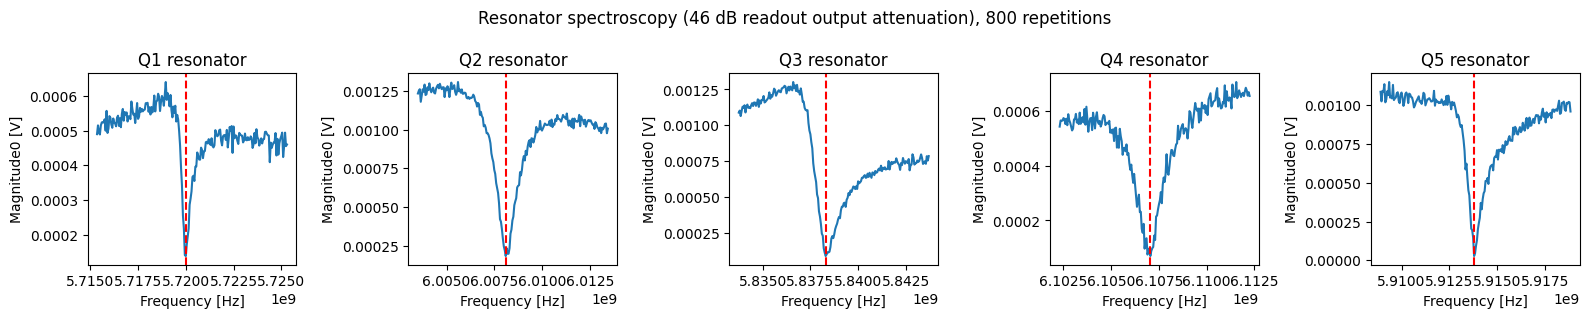

In [18]:
fig, ax = plt.subplots(1,5,figsize=plt.figaspect(1/5), sharey = False)

for i, rs_analysis in enumerate(rs_analyses):
    dh.to_gridded_dataset(rs_analysis.dataset).y0.plot(ax = ax[i])
    ax[i].axvline(quantum_device.get_element(f"Q{i+1}").clock_freqs.readout(), color = "red", ls = "--")
    ax[i].set_title(f"Q{i+1} resonator")
    
fig.suptitle(f"Resonator spectroscopy ({cluster.module8.out0_att()} dB readout output attenuation), {quantum_device.cfg_sched_repetitions()} repetitions")
fig.tight_layout()

In [21]:
for name in sorted(quantum_device.elements()):
    v = quantum_device.get_element(name).clock_freqs.readout
    print("readout frequency @ 0 V flux:", name, v(), v.unit)

readout frequency @ 0 V flux: Q1 5720000000.0 Hz
readout frequency @ 0 V flux: Q2 6008100000.0 Hz
readout frequency @ 0 V flux: Q3 5838300000.0 Hz
readout frequency @ 0 V flux: Q4 6107050000.0 Hz
readout frequency @ 0 V flux: Q5 5913800000.0 Hz


## (1.b) Resonator punchout
Before we set any parameters, confirm the resonator punchout

In [22]:
from quantify_core.analysis.base_analysis import Basic2DAnalysis

def run_resonator_punchout(
    qubit_device_element, /,
    out_att,
    repetitions = 800,
    ro_amp_step = 0.05,
    freq_span = 10e6,
    freq_step = 10e3,
):
    """
        NOTE: This program updates readout output attenuation for a qubit.
    """
    utils.tutorial_utils.set_readout_attenuation(quantum_device, qubit_device_element, out_att=out_att, in_att=0)

    freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
    freq.batched = True
    freq.batch_size = 1024

    ro_pulse_amp = ManualParameter(name="ro_pulse_amp", unit="", label="Readout pulse amplitude")
    ro_pulse_amp.batched = False

    spec_sched_kwargs = dict(
        pulse_amp=ro_pulse_amp,
        pulse_duration=4e-6,
        frequencies=freq,
        acquisition_delay=204e-9,
        integration_time=4e-6,
        init_duration=4e-9,
        port=qubit_device_element.ports.readout(),
        clock=qubit_device_element.name + ".ro",
    )

    out_att_str = f"({out_att} dB output attenuation)"

    utils.tutorial_utils.show_args(spec_sched_kwargs, title=f"Measurement parameters " + out_att_str)

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=heterodyne_spec_sched_nco,
        schedule_kwargs=spec_sched_kwargs,
        real_imag=False,
        batched=freq.batched,
    )

    meas_ctrl.gettables(gettable)
    center = qubit_device_element.clock_freqs.readout()

    quantum_device.cfg_sched_repetitions(repetitions)
    frequency_setpoints =  np.arange(center - freq_span/2, center + freq_span/2, freq_step)

    meas_ctrl.settables([freq, ro_pulse_amp])
    meas_ctrl.setpoints_grid((frequency_setpoints, np.arange(0, 1, ro_amp_step)))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        punchout_ds = meas_ctrl.run("Resonator punchout " + qubit_device_element.name + " " + out_att_str + " " + str(quantum_device.cfg_sched_repetitions()) + " repetitions")

    b2a = Basic2DAnalysis(tuid=punchout_ds.attrs["tuid"], dataset=punchout_ds)
    b2a_ = b2a.run()
    print()
    return b2a_

In [23]:
rp_analyses = [
    run_resonator_punchout(quantum_device.get_element(name), out_att = 20, freq_span = 4e6, freq_step=40e3, ro_amp_step=0.06)
    for name in ("Q1","Q2","Q3","Q4","Q5")
]

Measurement parameters (20 dB output attenuation)
pulse_amp         = ro_pulse_amp
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q1:res
clock             = Q1.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 ro_pulse_amp 
Batched settable(s):
	 freq 
Batch size limit: 1024

100% completed | elapsed time:     20s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     20s | time left:      0s  last batch size:    100  
Measurement parameters (20 dB output attenuation)
pulse_amp         = ro_pulse_amp
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q2:res
clock             = Q2.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 ro_pulse_amp 
Batched settable(s):
	 freq 
Batch size limit: 1024

100% compl

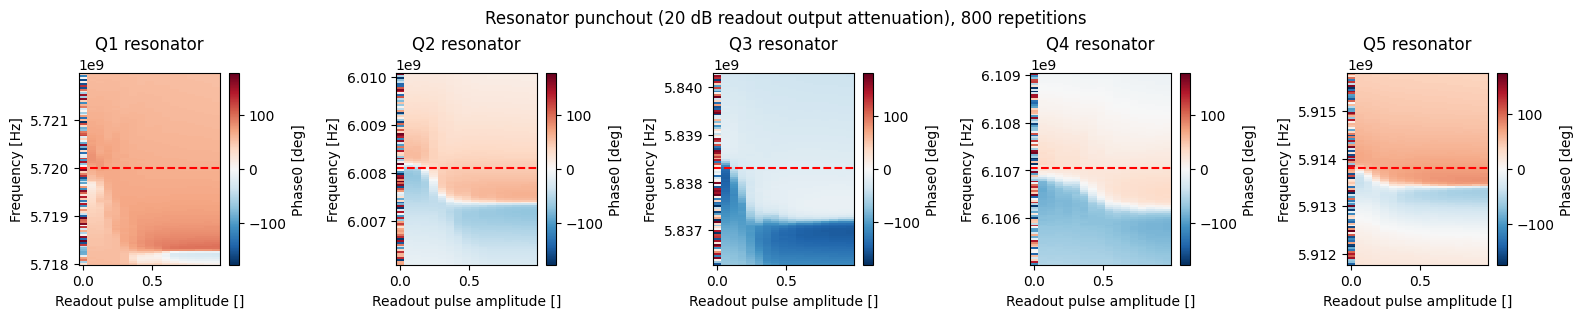

In [25]:
fig, ax = plt.subplots(1,5,figsize=plt.figaspect(1/5), sharey = False)

for i, rp_analysis in enumerate(rp_analyses):
    dh.to_gridded_dataset(rp_analysis.dataset).y1.plot(ax = ax[i])
    ax[i].axhline(quantum_device.get_element(f"Q{i+1}").clock_freqs.readout(), color = "red", ls = "--")
    ax[i].set_title(f"Q{i+1} resonator")
    
fig.suptitle(f"Resonator punchout ({cluster.module8.out0_att()} dB readout output attenuation), {quantum_device.cfg_sched_repetitions()} repetitions")
fig.tight_layout()

## (1.c) Resonator-flux spectroscopy

In [31]:
from itertools import product

def run_resonator_flux_spectroscopy(*,
    device_element_names : list,
    offset_settables_flux : list,
    out_att : int,
    repetitions : int = 80,
    freq_span : float = 10e6,
    freq_step : float = 10e3,
    diagonalized : bool = True,
    flux_setpoints = None
):
    executed_analyses = list()

    if diagonalized:
        pairwise_iterator = zip(device_element_names, offset_settables_flux)
    else:
        pairwise_iterator = product(device_element_names, offset_settables_flux)

    for device_element_name, cluster_mod2_offset in pairwise_iterator:
        for k, v in flux_settable_map.items():
            print("flux setpoint", k, v(), v.unit)
        print()

        qubit = quantum_device.get_element(device_element_name)
        utils.tutorial_utils.set_readout_attenuation(quantum_device, qubit, out_att=out_att, in_att=0)

        if not diagonalized:
            for settable in offset_settables_flux:
                settable(0.0)

        freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
        freq.batched = True

        flux_pulse_amp = ManualParameter(name="flux_pulse_amp", unit="", label="flux_pulse_amp")
        flux_pulse_amp.batched = False

        spec_sched_kwargs = dict(
            pulse_amp=1/5,
            pulse_duration=4e-6,
            frequencies=freq,
            acquisition_delay=204e-9,
            integration_time=4e-6,
            init_duration=4e-9,
            port=qubit.ports.readout(),
            clock=qubit.name + ".ro",
        )

        gettable = ScheduleGettable(
            quantum_device,
            schedule_function=heterodyne_spec_sched_nco,
            schedule_kwargs=spec_sched_kwargs,
            real_imag=False,
            batched=freq.batched,
        )

        meas_ctrl.gettables(gettable)

        quantum_device.cfg_sched_repetitions(repetitions)
        center = qubit.clock_freqs.readout()
        frequency_setpoints = np.arange(center - freq_span/2, center + freq_span/2, freq_step)

        meas_ctrl.settables([freq, cluster_mod2_offset])
        meas_ctrl.setpoints_grid((frequency_setpoints, flux_setpoints))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            rfs_ds = meas_ctrl.run("rfs " + qubit.name + " with " + cluster_mod2_offset.name + f" {quantum_device.cfg_sched_repetitions()} repetitions")
            
        rfs_analysis = utils.tutorial_analysis_classes.ResonatorFluxSpectroscopyAnalysis(tuid=rfs_ds.attrs["tuid"], dataset=rfs_ds)

        executed_analyses.append(rfs_analysis.run(fit_method="fast", sweetspot_index=0))

        # Update the flux sweetspot
        flux_settable_map[qubit.name](rfs_analysis.quantities_of_interest["offset_0"].nominal_value)
        print()
        
    return executed_analyses

In [35]:
rfsa_analyses_diag = run_resonator_flux_spectroscopy(
    freq_span = 4e6,
    freq_step = 50e3,
    flux_setpoints = np.linspace(-0.4, 0.4, 30),
    out_att = 46,
    device_element_names = ("Q1","Q2","Q3","Q4","Q5"),
    offset_settables_flux = (cluster.module2.out0_offset, cluster.module2.out1_offset, cluster.module2.out2_offset, cluster.module2.out3_offset, cluster.module10.out0_offset)
)

flux setpoint Q1 0.0 V
flux setpoint Q2 0.0 V
flux setpoint Q3 0.0 V
flux setpoint Q4 0.0 V
flux setpoint Q5 0.0 V

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out0_offset 
Batched settable(s):
	 freq 
Batch size limit: 1024



100% completed | elapsed time:     37s | time left:      0s  last batch size:     80  
100% completed | elapsed time:     37s | time left:      0s  last batch size:     80  
flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.0 V
flux setpoint Q3 0.0 V
flux setpoint Q4 0.0 V
flux setpoint Q5 0.0 V

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out1_offset 
Batched settable(s):
	 freq 
Batch size limit: 1024

100% completed | elapsed time:     38s | time left:      0s  last batch size:     80  
100% completed | elapsed time:     38s | time left:      0s  last batch size:     80  
flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.125925064086914 V
flux setpoint Q3 0.0 V
flux setpoint Q4 0.0 V
flux setpoint Q5 0.0 V

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 out2_offset 
Batched settable(s):
	 freq 
Batch size limit: 1024

100% completed | elapsed time:     38s | time left:      0s  last batch size:     80  
100% comple

In [41]:
for k, v in flux_settable_map.items():
    print("flux setpoint", k, v(), v.unit)

flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.125925064086914 V
flux setpoint Q3 0.0928130149841309 V
flux setpoint Q4 0.0928130149841309 V
flux setpoint Q5 0.113107442855835 V


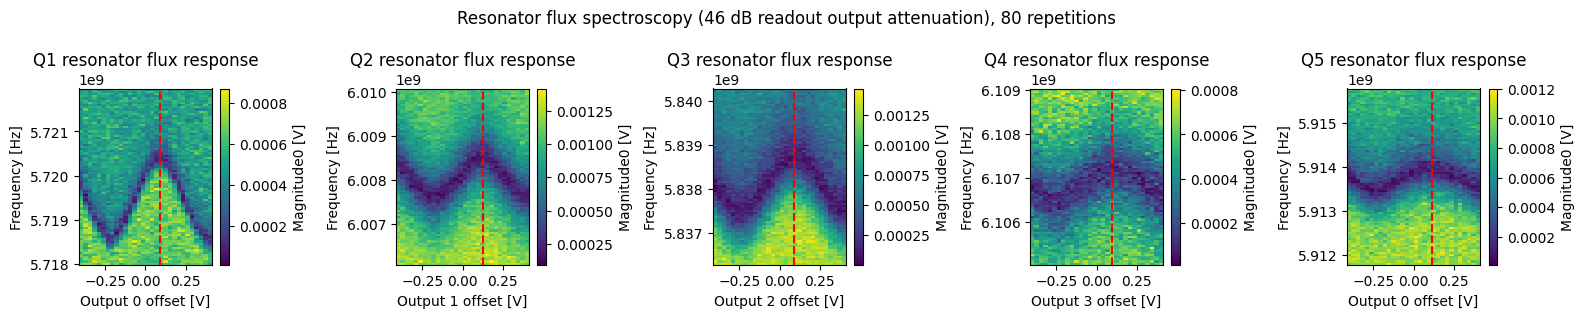

In [38]:
fig, ax = plt.subplots(1,5,figsize=plt.figaspect(1/5), sharey = False)

for i, rfs_analysis in enumerate(rfsa_analyses_diag):
    rfs_analysis.dataset_processed.y0.plot(ax = ax[i])
    sweetspot = flux_settable_map[f"Q{i+1}"]()
    ax[i].axvline(sweetspot, color = "red", ls = "--")
    ax[i].set_title(f"Q{i+1} resonator flux response")
    
fig.suptitle(f"Resonator flux spectroscopy ({cluster.module8.out0_att()} dB readout output attenuation), {quantum_device.cfg_sched_repetitions()} repetitions")
fig.tight_layout()

In [40]:
# re-run resonator spectroscopy for the new readout frequency at the sweetspot
rs_analyses = [
    run_resonator_spectroscopy(quantum_device.get_element(name), step = 50e3, out_att = 46)
    for name in ("Q1","Q2","Q3","Q4","Q5")
]

Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q1:res
clock             = Q1.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  
100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  

c:\Users\Scientek\miniconda3\envs\qblox\lib\site-packages\quantify_core\analysis\base_analysis.py:893: UserWarning: fit failed. lmfit was not able to fit the data.
  warnings.warn(fit_warning)



Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q2:res
clock             = Q2.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  
100% completed | elapsed time:      1s | time left:      0s  last batch size:    200  
Measurement parameters (46 dB output attenuation)
pulse_amp         = 0.2
pulse_duration    = 4e-06
frequencies       = freq
acquisition_delay = 2.04e-07
integration_time  = 4e-06
init_duration     = 4e-09
port              = Q3:res
clock             = Q3.ro
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 200

100% completed | elapsed 

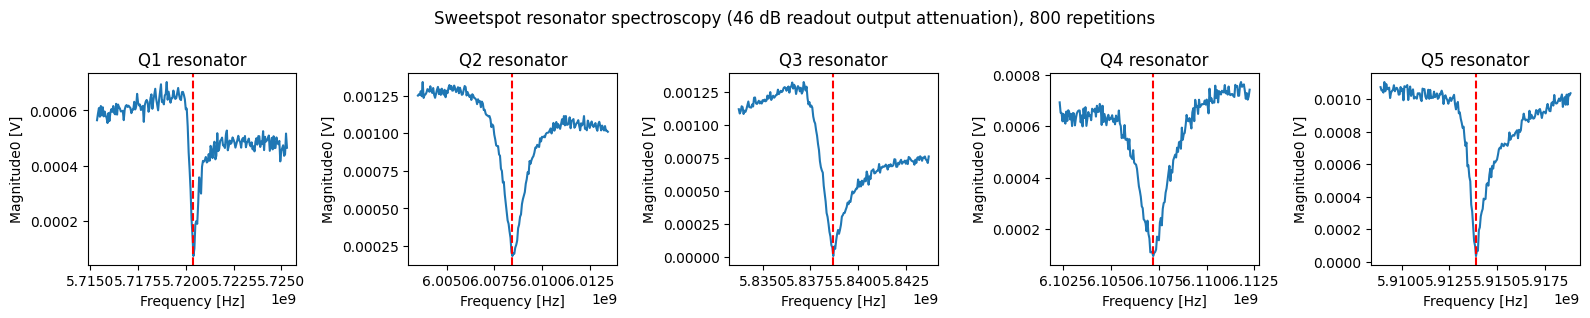

In [44]:
fig, ax = plt.subplots(1,5,figsize=plt.figaspect(1/5), sharey = False)

for i, rs_analysis in enumerate(rs_analyses):
    dh.to_gridded_dataset(rs_analysis.dataset).y0.plot(ax = ax[i])
    ax[i].axvline(quantum_device.get_element(f"Q{i+1}").clock_freqs.readout(), color = "red", ls = "--")
    ax[i].set_title(f"Q{i+1} resonator")
    
fig.suptitle(f"Sweetspot resonator spectroscopy ({cluster.module8.out0_att()} dB readout output attenuation), {quantum_device.cfg_sched_repetitions()} repetitions")
fig.tight_layout()

In [49]:
for name in sorted(quantum_device.elements()):
    v = quantum_device.get_element(name).clock_freqs.readout
    print(f"readout frequency @ {flux_settable_map[name]()} V flux:", name, v(), v.unit)

readout frequency @ 0.0917067527770996 V flux: Q1 5720400000.0 Hz
readout frequency @ 0.125925064086914 V flux: Q2 6008450000.0 Hz
readout frequency @ 0.0928130149841309 V flux: Q3 5838700000.0 Hz
readout frequency @ 0.0928130149841309 V flux: Q4 6107200000.0 Hz
readout frequency @ 0.113107442855835 V flux: Q5 5913900000.0 Hz


## (2.a) Qubit spectroscopy

In [48]:
# we now fix the measure gate, we do this by setting the quantum device parameters and use 46 dB attenuation
def set_measure_gate(qubit_device_element):
    spec_sched_kwargs = dict(
        pulse_amp=1/5,
        pulse_duration=4e-6,
        acquisition_delay=204e-9,
        integration_time=4e-6,
        init_duration=4e-9,
        port=qubit_device_element.ports.readout(),
        clock=qubit_device_element.name + ".ro",
    )

    # set readout pulse parameterization
    qubit_device_element.measure.pulse_amp(spec_sched_kwargs["pulse_amp"])
    qubit_device_element.measure.pulse_duration(spec_sched_kwargs["pulse_duration"])
    qubit_device_element.measure.acq_delay(204e-9)
    qubit_device_element.reset.duration(100e-6)
    qubit_device_element.measure.integration_time(spec_sched_kwargs["integration_time"])

for device_element_name in quantum_device.elements():
    set_measure_gate(quantum_device.get_element(device_element_name))

In [50]:
from quantify_core.analysis.spectroscopy_analysis import QubitSpectroscopyAnalysis
from quantify_scheduler.operations.gate_library import Measure, Reset
from quantify_scheduler.operations.pulse_library import SetClockFrequency, SquarePulse, VoltageOffset
from quantify_scheduler.resources import ClockResource
from quantify_scheduler.schedules.schedule import Schedule

def run_two_tone(
    qubit_device_element, /,
    freq_span : float,
    freq_step : float,
    repetitions = 800,
    freq_center = None,
    drive_out_att = 60
):
    def _two_tone_spec_sched_nco(
        qubit_name: str,
        spec_pulse_port: str,
        spec_pulse_clock: str,
        spec_pulse_frequencies: np.ndarray,
        repetitions: int = 1,
    ) -> Schedule:
        sched = Schedule("two-tone", repetitions)
        sched.add_resource(ClockResource(name=spec_pulse_clock, freq=spec_pulse_frequencies.flat[0]))

        for acq_idx, spec_pulse_freq in enumerate(spec_pulse_frequencies):
            #sched.add(Reset(qubit_device_element.name))
            sched.add(SetClockFrequency(clock=spec_pulse_clock, clock_freq_new=spec_pulse_freq))
            sched.add(
                VoltageOffset(
                    offset_path_0=1,
                    offset_path_1=1,
                    port=spec_pulse_port,
                    clock=spec_pulse_clock
                )
            )
            sched.add(Measure(qubit_name, acq_index=acq_idx))

        return sched

    utils.tutorial_utils.set_drive_attenuation(quantum_device, qubit_device_element, out_att=drive_out_att)
    utils.tutorial_utils.set_readout_attenuation(quantum_device, qubit_device_element, out_att=46, in_att=0)

    freq = ManualParameter(name="freq", unit="Hz", label="Frequency")
    freq.batched = True

    qubit_spec_sched_kwargs = dict(
        qubit_name=qubit_device_element.name,
        spec_pulse_frequencies=freq,
        spec_pulse_port=qubit_device_element.ports.microwave(),
        spec_pulse_clock=qubit_device_element.name + ".01"
    )

    out_att_str = f"({drive_out_att} dB drive output att)"

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=_two_tone_spec_sched_nco,
        schedule_kwargs=qubit_spec_sched_kwargs,
        real_imag=False,
        batched=freq.batched,
    )

    meas_ctrl.gettables(gettable)
    
    if freq_center is None:
        freq_center = qubit_device_element.clock_freqs.f01()

    quantum_device.cfg_sched_repetitions(repetitions)
    frequency_setpoints =  np.arange(freq_center - freq_span/2, freq_center + freq_span/2, freq_step)

    meas_ctrl.settables(freq)
    meas_ctrl.setpoints(frequency_setpoints)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        qs_ds = meas_ctrl.run("Two-tone " + qubit_device_element.name + " " + out_att_str + f", {quantum_device.cfg_sched_repetitions()} repetitions")

    qsa = QubitSpectroscopyAnalysis(tuid=qs_ds.attrs["tuid"], dataset=qs_ds)
    qsa_ = qsa.run()

    qubit_device_element.clock_freqs.f01(qsa_.quantities_of_interest["frequency_01"].nominal_value) # SET NEW VALUE !
    print()
    return qsa_

In [53]:
for k, v in flux_settable_map.items():
    print("flux setpoint", k, v(), v.unit)

flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.125925064086914 V
flux setpoint Q3 0.0928130149841309 V
flux setpoint Q4 0.0928130149841309 V
flux setpoint Q5 0.113107442855835 V


Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 1024



 40% completed | elapsed time:     11s | time left:     16s  last batch size:   1024  

 81% completed | elapsed time:     22s | time left:      4s  last batch size:   1024  

100% completed | elapsed time:     27s | time left:      0s  last batch size:    452  
100% completed | elapsed time:     27s | time left:      0s  last batch size:    452  


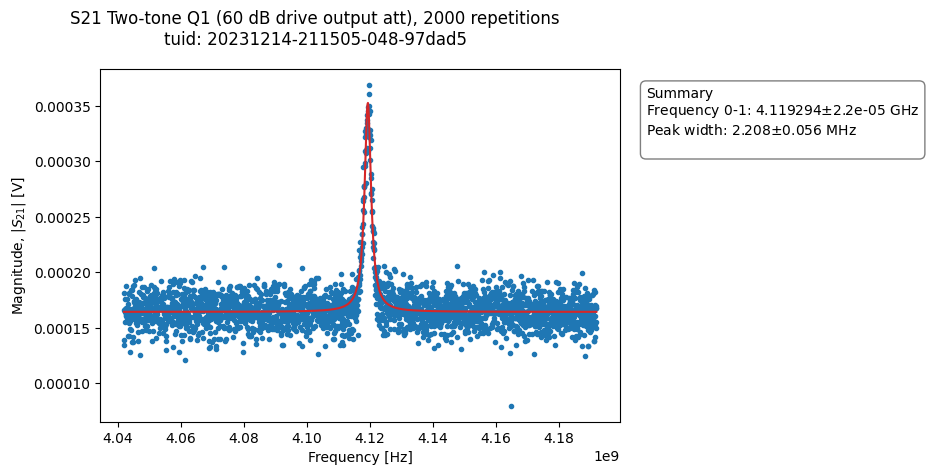

In [52]:
run_two_tone(
    quantum_device.get_element("Q1"),
    freq_center = estimate_f_qubits["Q1"],
    freq_span = 150e6,
    freq_step = 60e3,
    drive_out_att = 60,
    repetitions = 2000
).display_figs_mpl()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 1024



 61% completed | elapsed time:     11s | time left:      6s  last batch size:   1024  

100% completed | elapsed time:     17s | time left:      0s  last batch size:    643  
100% completed | elapsed time:     17s | time left:      0s  last batch size:    643  


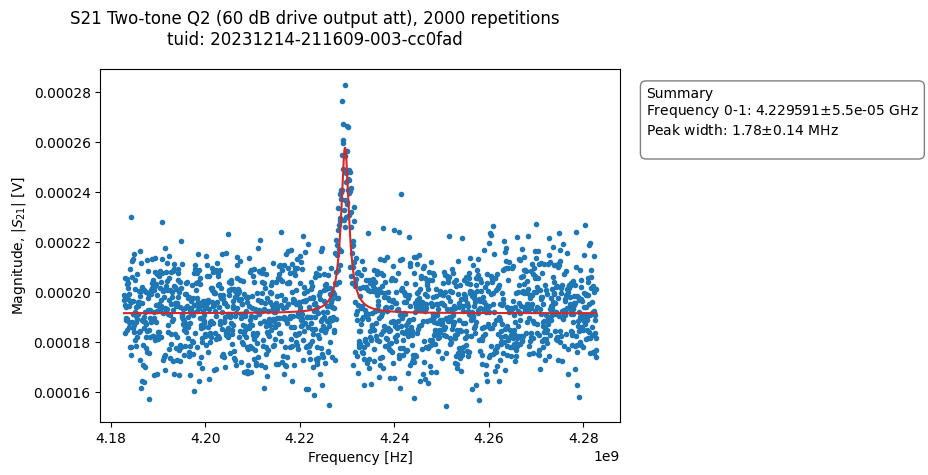

In [54]:
run_two_tone(
    quantum_device.get_element("Q2"),
    freq_center = estimate_f_qubits["Q2"],
    freq_span = 100e6,
    freq_step = 60e3,
    drive_out_att = 60,
    repetitions = 2000
).display_figs_mpl()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 1000



100% completed | elapsed time:     11s | time left:      0s  last batch size:   1000  
100% completed | elapsed time:     11s | time left:      0s  last batch size:   1000  


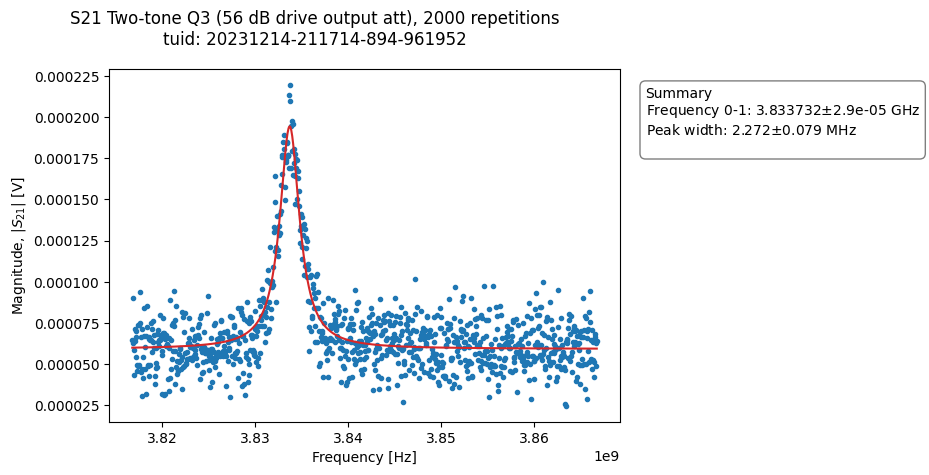

In [55]:
run_two_tone(
    quantum_device.get_element("Q3"),
    freq_center = estimate_f_qubits["Q3"],
    freq_span = 50e6,
    freq_step = 50e3,
    drive_out_att = 56,
    repetitions = 2000
).display_figs_mpl()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 1024



 51% completed | elapsed time:     10s | time left:     10s  last batch size:   1024  

100% completed | elapsed time:     21s | time left:      0s  last batch size:    976  
100% completed | elapsed time:     21s | time left:      0s  last batch size:    976  


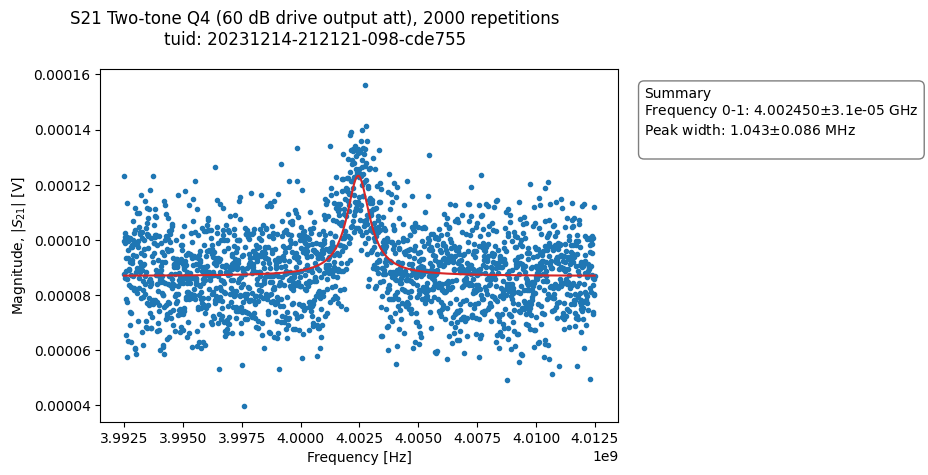

In [62]:
run_two_tone(
    quantum_device.get_element("Q4"),
    # freq_center = estimate_f_qubits["Q4"],
    freq_center = 4.0025e9,
    freq_span = 20e6,
    freq_step = 10e3,
    drive_out_att = 60,
    repetitions = 2000
).display_figs_mpl()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 freq 
Batch size limit: 1024



 30% completed | elapsed time:     11s | time left:     24s  last batch size:   1024  

 61% completed | elapsed time:     22s | time left:     13s  last batch size:   1024  

 92% completed | elapsed time:     32s | time left:      2s  last batch size:   1024  

100% completed | elapsed time:     36s | time left:      0s  last batch size:    262  
100% completed | elapsed time:     36s | time left:      0s  last batch size:    262  


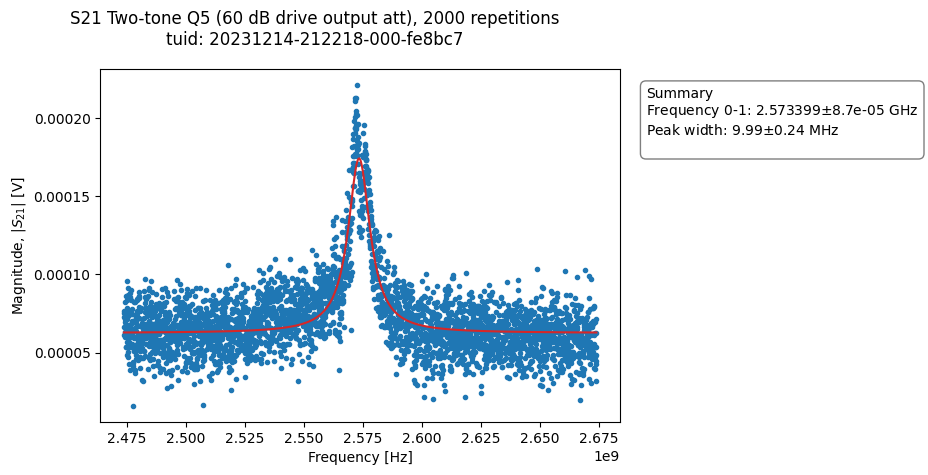

In [64]:
run_two_tone(
    quantum_device.get_element("Q5"),
    freq_center = estimate_f_qubits["Q5"],
    freq_span = 200e6,
    freq_step = 60e3,
    drive_out_att = 60,
    repetitions = 2000
).display_figs_mpl()

In [89]:
for name in sorted(quantum_device.elements()):
    v = quantum_device.get_element(name).clock_freqs.f01
    print(f"f01 frequency @ {flux_settable_map[name]()} V flux:", name, v(), v.unit)

f01 frequency @ 0.0917067527770996 V flux: Q1 4119294171.4717703 Hz
f01 frequency @ 0.125925064086914 V flux: Q2 4229590667.972118 Hz
f01 frequency @ 0.0928130149841309 V flux: Q3 3833732160.515083 Hz
f01 frequency @ 0.0928130149841309 V flux: Q4 4002449677.6266613 Hz
f01 frequency @ 0.113107442855835 V flux: Q5 2573399120.4856114 Hz


In [90]:
# because we want to reset the flux after every qubit flux spectroscopy, do them one at a time
flux_settable_map["Q1"](0.0917067527770996)
flux_settable_map["Q2"](0.125925064086914)
flux_settable_map["Q3"](0.0928130149841309)
flux_settable_map["Q4"](0.0928130149841309)
flux_settable_map["Q5"](0.113107442855835)

## (3.) Rabi oscillations

In [91]:
from quantify_scheduler.schedules import rabi_sched
from quantify_core.analysis.single_qubit_timedomain import RabiAnalysis

def run_rabi(qubit_device_element, /, out_att : int, repetitions = 800, drive_amp_step = 0.001):
    """
        NOTE: This program sets the amp180 parameter and the drive attenuation for the qubit.
    """
    pulse_amp = ManualParameter(name="pulse_amplitude", unit="", label="")
    pulse_amp.batched = True

    rabi_sched_kwargs = {
        "pulse_amp": pulse_amp,
        "pulse_duration": 80e-9,
        "frequency": qubit_device_element.clock_freqs.f01(),
        "qubit": qubit_device_element.name,
    }

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=rabi_sched,
        schedule_kwargs=rabi_sched_kwargs,
        batched=True,
    )

    meas_ctrl.gettables(gettable)

    out_att_str = f"(Drive output attenuation {out_att} dB)"

    utils.tutorial_utils.set_drive_attenuation(quantum_device, qubit_device_element, out_att=out_att)
    utils.tutorial_utils.set_readout_attenuation(quantum_device, qubit_device_element, out_att=46, in_att=0)

    quantum_device.cfg_sched_repetitions(repetitions)

    amplitude_setpoints = np.arange(-.15, .15, drive_amp_step)

    meas_ctrl.settables(pulse_amp)
    meas_ctrl.setpoints(amplitude_setpoints)

    rabi_ds = meas_ctrl.run("Rabi " + qubit_device_element.name + " " + out_att_str)
    rabi_analysis = RabiAnalysis(tuid=rabi_ds.attrs["tuid"], dataset=rabi_ds)
    ra = rabi_analysis.run()
    
    qubit_device_element.rxy.amp180(ra.quantities_of_interest["Pi-pulse amplitude"].nominal_value)

    print()
    return ra

In [92]:
rabi_analyses = [
    run_rabi(
        quantum_device.get_element(name),
        out_att=att,
        drive_amp_step = 0.004,
        repetitions=2000,
    )
    for name, att in (("Q1", 6),("Q2", 10),("Q3",6),("Q4", 6),("Q5", 6))
]

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 75



100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 75



100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 75



100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 75



100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 pulse_amplitude 
Batch size limit: 75



100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  
100% completed | elapsed time:     16s | time left:      0s  last batch size:     75  


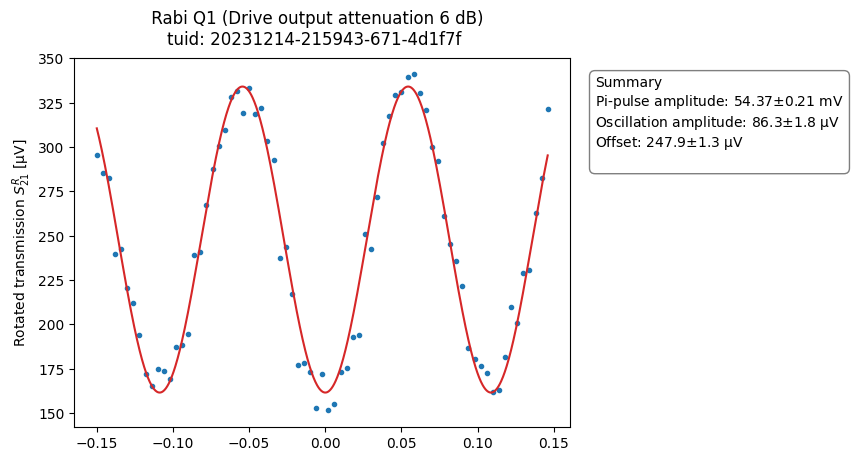

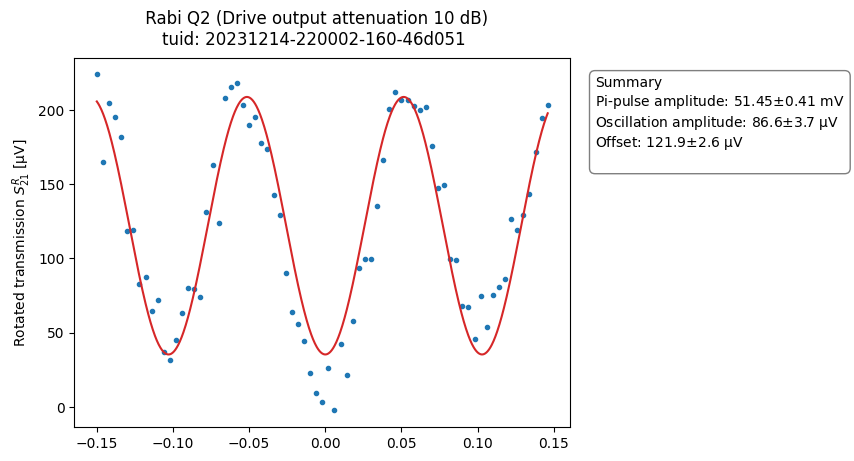

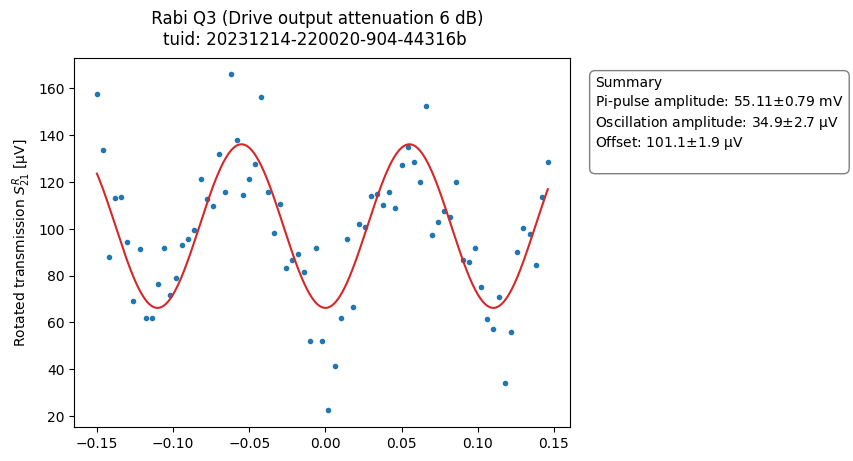

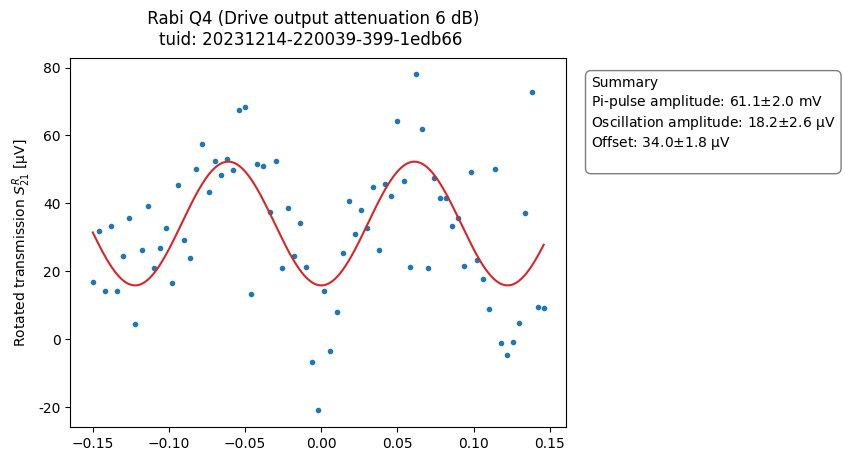

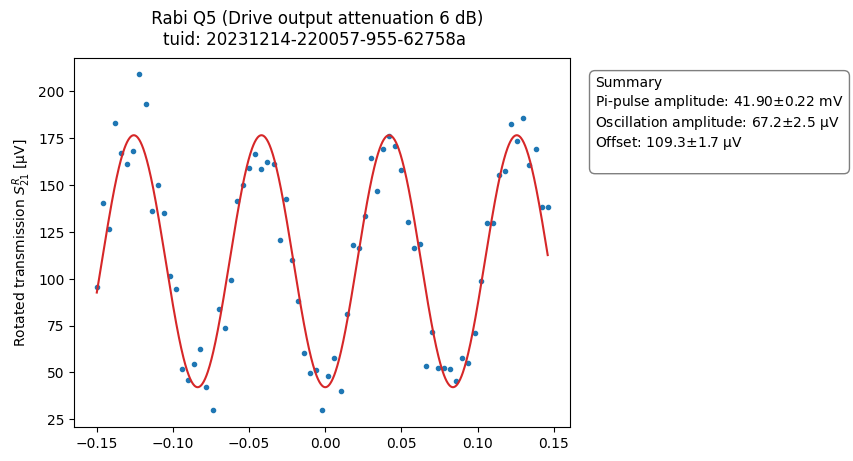

In [94]:
for i, name in enumerate(("Q1","Q2","Q3","Q4","Q5")):
    rabi_analysis = rabi_analyses[i]
    rabi_analysis.display_figs_mpl()

In [95]:
for name in ("Q1","Q2","Q3","Q4","Q5"):
    v = quantum_device.get_element(name).rxy.amp180
    print("rabi x180 amplitude", name, v(), v.unit)

rabi x180 amplitude Q1 0.05436838893973086 
rabi x180 amplitude Q2 0.05144829495914275 
rabi x180 amplitude Q3 0.0551147063381517 
rabi x180 amplitude Q4 0.06112750231622456 
rabi x180 amplitude Q5 0.041899619746331176 


In [96]:
quantum_device.get_element("Q1").rxy.duration(80e-9)
quantum_device.get_element("Q2").rxy.duration(80e-9)
quantum_device.get_element("Q3").rxy.duration(80e-9)
quantum_device.get_element("Q4").rxy.duration(80e-9)
quantum_device.get_element("Q5").rxy.duration(80e-9)

## (4.) Ramsey oscillations

In [99]:
from quantify_scheduler.schedules.timedomain_schedules import ramsey_sched
from quantify_core.analysis.single_qubit_timedomain import RamseyAnalysis

def run_ramsey(qubit_device_element, /, tau_setpoints, artificial_detuning, repetitions : int = 300):
    tau = ManualParameter(name="tau", unit="s", label="Time")
    tau.batched = True

    ramsey_sched_kwargs = {
        "qubit": qubit_device_element.name,
        "times": tau,
        "artificial_detuning": artificial_detuning,
    }

    utils.tutorial_utils.show_drive_args(qubit_device_element)

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=ramsey_sched,
        schedule_kwargs=ramsey_sched_kwargs,
        real_imag=False,
        batched=tau.batched,
    )
    meas_ctrl.gettables(gettable)

    meas_ctrl.settables(tau)
    meas_ctrl.setpoints(tau_setpoints)

    quantum_device.cfg_sched_repetitions(repetitions)
    ramsey_ds = meas_ctrl.run("Ramsey " + qubit_device_element.name + f" {quantum_device.cfg_sched_repetitions()} repetitions")
    ramsey_analysis = RamseyAnalysis(tuid=ramsey_ds.attrs["tuid"], dataset=ramsey_ds)
    ram_analysis = ramsey_analysis.run(
        artificial_detuning=ramsey_sched_kwargs["artificial_detuning"]
    )
    print()
    return ram_analysis

In [102]:
ramsey_analyses = [
    run_ramsey(
        qubit,
        tau_setpoints=np.arange(80e-9, 2000e-9, 12e-9),
        artificial_detuning= 50e3,
        repetitions=2000
    ) for qubit in sorted(
        list(map(quantum_device.get_element, quantum_device.elements())),
        key=lambda element: element.name,
    )
]

Q1.rxy
amp180   = 0.05436838893973086
motzoi   = 0
duration = 8e-08

Q1.clock_freqs
f01 = 4119294171.4717703
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 160



100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
Q2.rxy
amp180   = 0.05144829495914275
motzoi   = 0
duration = 8e-08

Q2.clock_freqs
f01 = 4229590667.972118
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 160



100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
Q3.rxy
amp180   = 0.0551147063381517
motzoi   = 0
duration = 8e-08

Q3.clock_freqs
f01 = 3833732160.515083
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 160



100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
Q4.rxy
amp180   = 0.06112750231622456
motzoi   = 0
duration = 8e-08

Q4.clock_freqs
f01 = 4002449677.6266613
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 160



100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
Q5.rxy
amp180   = 0.041899619746331176
motzoi   = 0
duration = 8e-08

Q5.clock_freqs
f01 = 2573399120.4856114
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 160



100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  
100% completed | elapsed time:     35s | time left:      0s  last batch size:    160  


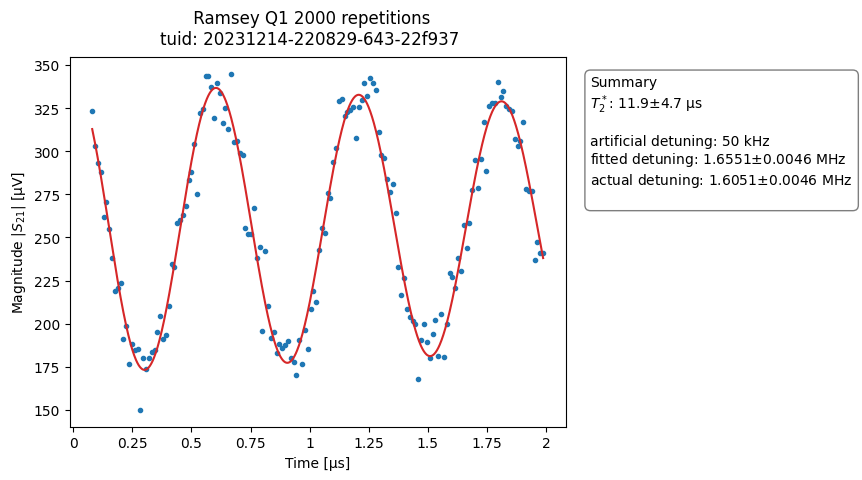

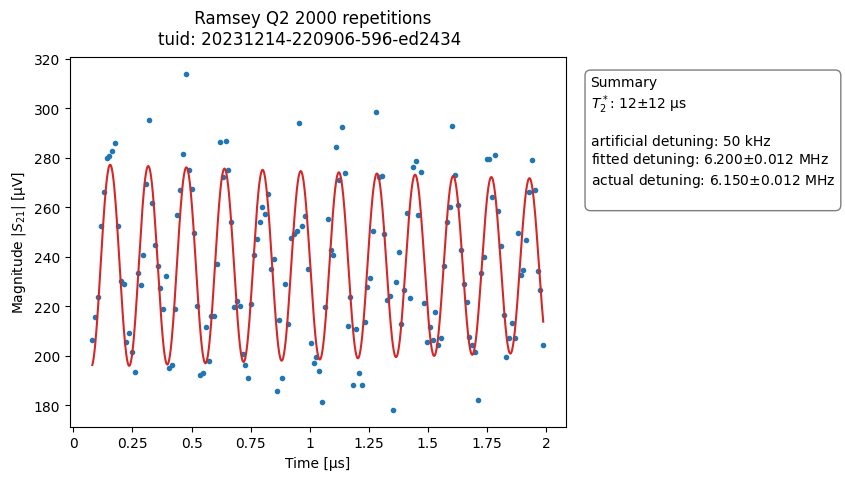

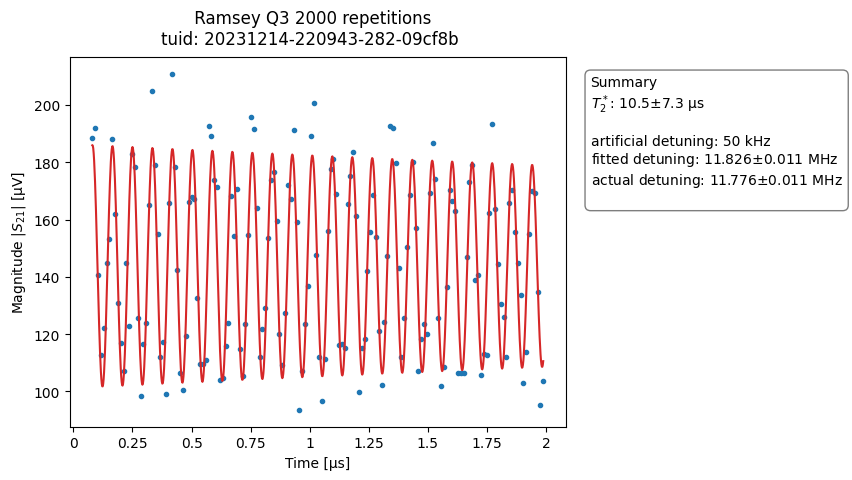

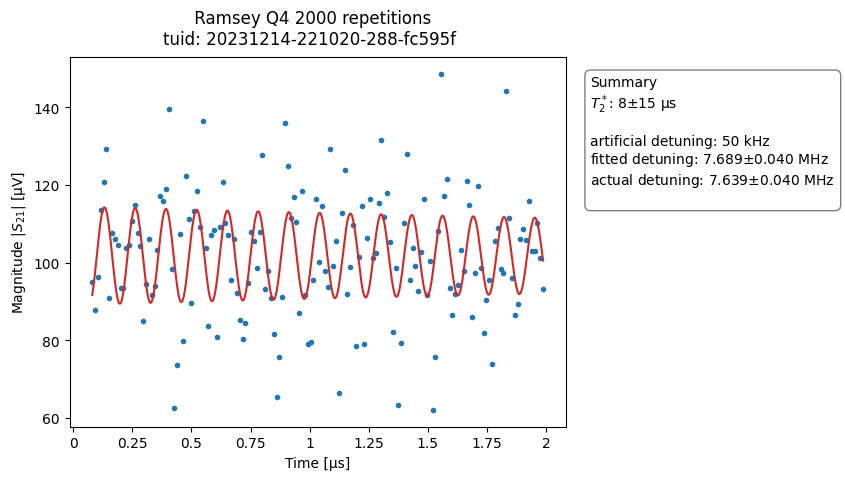

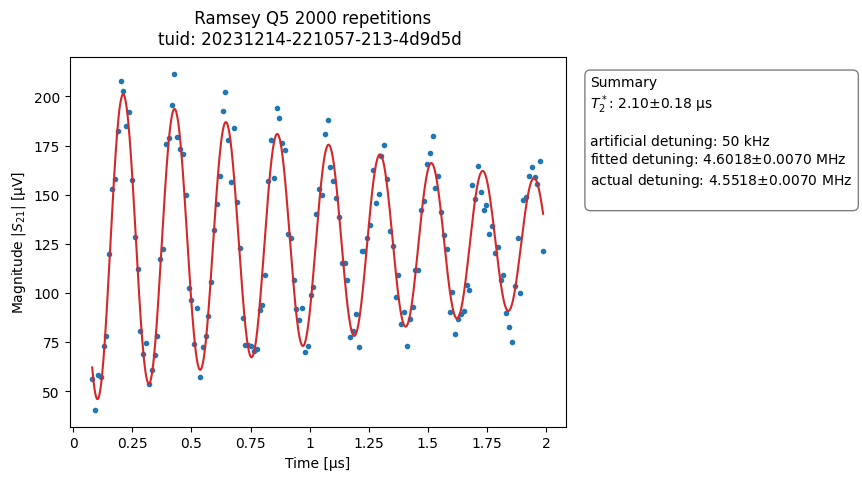

In [103]:
for analysis in ramsey_analyses:
    analysis.display_figs_mpl()

In [104]:
ordered_elements = sorted(
    list(map(quantum_device.get_element, quantum_device.elements())),
    key=lambda element: element.name,
)

In [105]:
for qubit_device_element, analysis in zip(ordered_elements, ramsey_analyses):
    qubit_device_element.clock_freqs.f01(
        qubit_device_element.clock_freqs.f01() + analysis.quantities_of_interest["detuning"].nominal_value/1.002
    )

In [106]:
for k, v in flux_settable_map.items():
    print("flux setpoint", k, v(), v.unit)

flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.125925064086914 V
flux setpoint Q3 0.0928130149841309 V
flux setpoint Q4 0.0928130149841309 V
flux setpoint Q5 0.113107442855835 V


In [107]:
ramsey_analyses_fine = [
    run_ramsey(
        qubit,
        tau_setpoints=np.arange(80e-9, 2000e-9, 60e-9),
        artificial_detuning= 100e3,
        repetitions=500
    ) for qubit in ordered_elements
]

Q1.rxy
amp180   = 0.05436838893973086
motzoi   = 0
duration = 8e-08

Q1.clock_freqs
f01 = 4120896056.8635917
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 32



100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
Q2.rxy
amp180   = 0.05144829495914275
motzoi   = 0
duration = 8e-08

Q2.clock_freqs
f01 = 4235728103.1632237
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 32



100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
Q3.rxy
amp180   = 0.0551147063381517
motzoi   = 0
duration = 8e-08

Q3.clock_freqs
f01 = 3845484264.3353825
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 32



100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
Q4.rxy
amp180   = 0.06112750231622456
motzoi   = 0
duration = 8e-08

Q4.clock_freqs
f01 = 4010073001.7032466
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 32



100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
100% completed | elapsed time:      2s | time left:      0s  last batch size:     32  
Q5.rxy
amp180   = 0.041899619746331176
motzoi   = 0
duration = 8e-08

Q5.clock_freqs
f01 = 2577941815.8049436
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau 
Batch size limit: 32



100% completed | elapsed time:      3s | time left:      0s  last batch size:     32  
100% completed | elapsed time:      3s | time left:      0s  last batch size:     32  


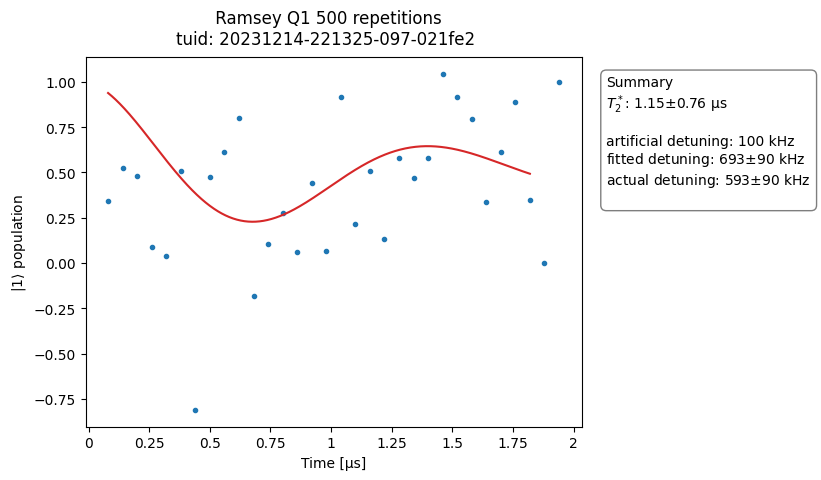

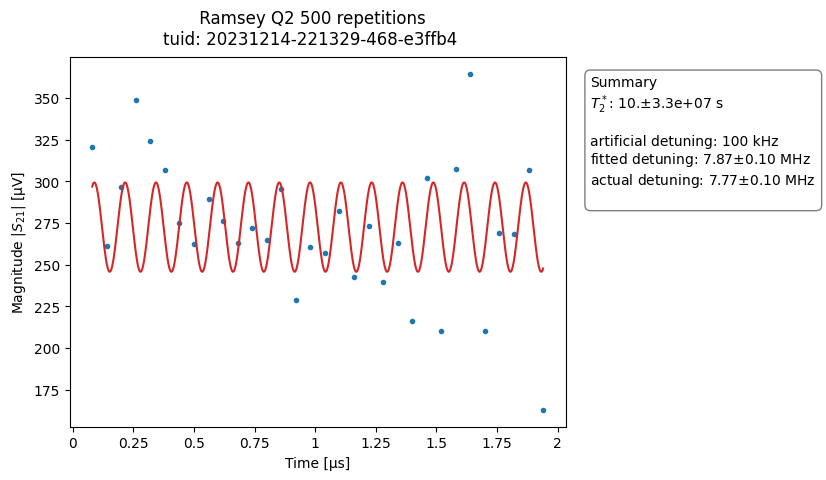

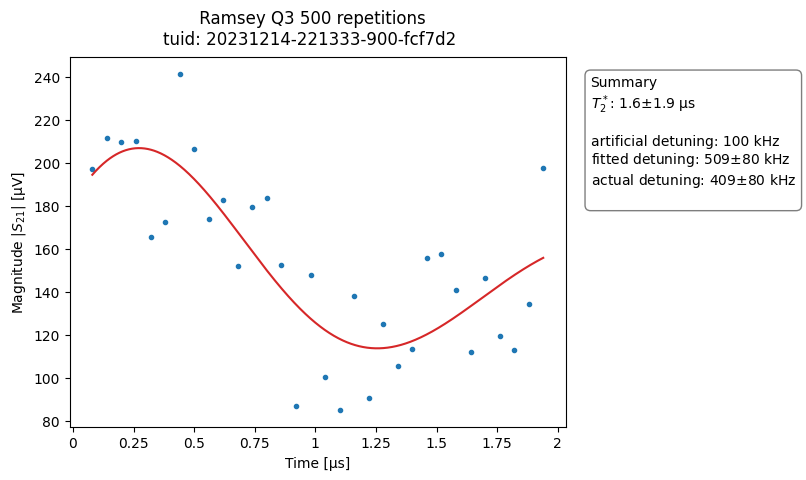

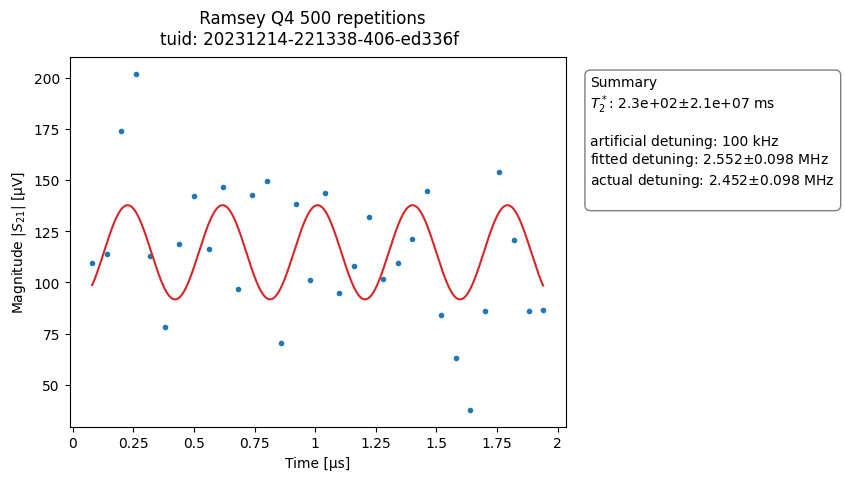

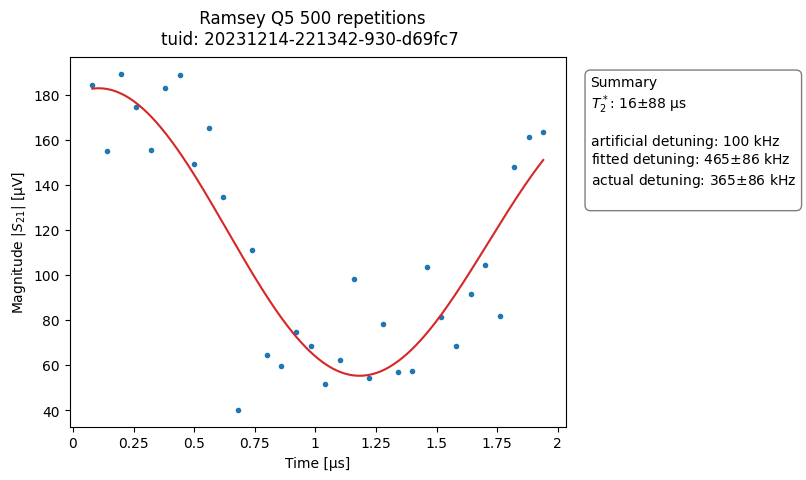

In [108]:
for analysis in ramsey_analyses_fine:
    analysis.display_figs_mpl()

In [109]:
for name in sorted(quantum_device.elements()):
    v = quantum_device.get_element(name).clock_freqs.f01
    print(f"f01 frequency @ {flux_settable_map[name]()} V flux:", name, v(), v.unit)

f01 frequency @ 0.0917067527770996 V flux: Q1 4120896056.8635917 Hz
f01 frequency @ 0.125925064086914 V flux: Q2 4235728103.1632237 Hz
f01 frequency @ 0.0928130149841309 V flux: Q3 3845484264.3353825 Hz
f01 frequency @ 0.0928130149841309 V flux: Q4 4010073001.7032466 Hz
f01 frequency @ 0.113107442855835 V flux: Q5 2577941815.8049436 Hz


## (5.) T1

In [115]:
from quantify_scheduler.schedules import t1_sched
from quantify_core.analysis.single_qubit_timedomain import T1Analysis

def run_t1(qubit_device_element, /, repetitions : int = 2000):
    tau = ManualParameter(name="tau_delay", unit="s", label="Delay")
    tau.batched = True

    utils.tutorial_utils.show_drive_args(qubit_device_element)

    t1_sched_kwargs = {"qubit": qubit_device_element.name, "times": tau}

    gettable = ScheduleGettable(
        quantum_device,
        schedule_function=t1_sched,
        schedule_kwargs=t1_sched_kwargs,
        real_imag=False,
        batched=tau.batched,
    )
    meas_ctrl.gettables(gettable)

    #utils.tutorial_utils.show_args(t1_sched_kwargs, title="t1_sched_kwargs")

    delay_setpoints = np.arange(40e-9, 50e-6, 500e-9)

    meas_ctrl.settables(tau)
    meas_ctrl.setpoints(delay_setpoints)

    quantum_device.cfg_sched_repetitions(repetitions)
    t1_ds = meas_ctrl.run("T1 experiment " + qubit_device_element.name + f" {quantum_device.cfg_sched_repetitions()} repetitions")
    t1_analysis = T1Analysis(tuid=t1_ds.attrs["tuid"], dataset=t1_ds)

    return t1_analysis.run()

In [116]:
t1_analyses = [
    run_t1(qubit)
    for qubit in ordered_elements
]

Q1.rxy
amp180   = 0.05436838893973086
motzoi   = 0
duration = 8e-08

Q1.clock_freqs
f01 = 4120896056.8635917
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 100



100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  Q2.rxy
amp180   = 0.05144829495914275
motzoi   = 0
duration = 8e-08

Q2.clock_freqs
f01 = 4235728103.1632237
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 100



100% completed | elapsed time:     26s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     26s | time left:      0s  last batch size:    100  Q3.rxy
amp180   = 0.0551147063381517
motzoi   = 0
duration = 8e-08

Q3.clock_freqs
f01 = 3845484264.3353825
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 100



100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  Q4.rxy
amp180   = 0.06112750231622456
motzoi   = 0
duration = 8e-08

Q4.clock_freqs
f01 = 4010073001.7032466
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 100



100% completed | elapsed time:     26s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     26s | time left:      0s  last batch size:    100  Q5.rxy
amp180   = 0.041899619746331176
motzoi   = 0
duration = 8e-08

Q5.clock_freqs
f01 = 2577941815.8049436
Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 tau_delay 
Batch size limit: 100



100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  
100% completed | elapsed time:     27s | time left:      0s  last batch size:    100  

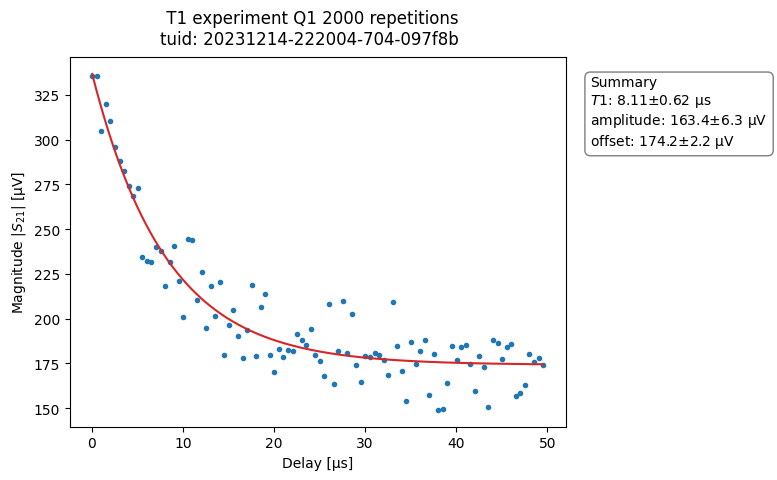

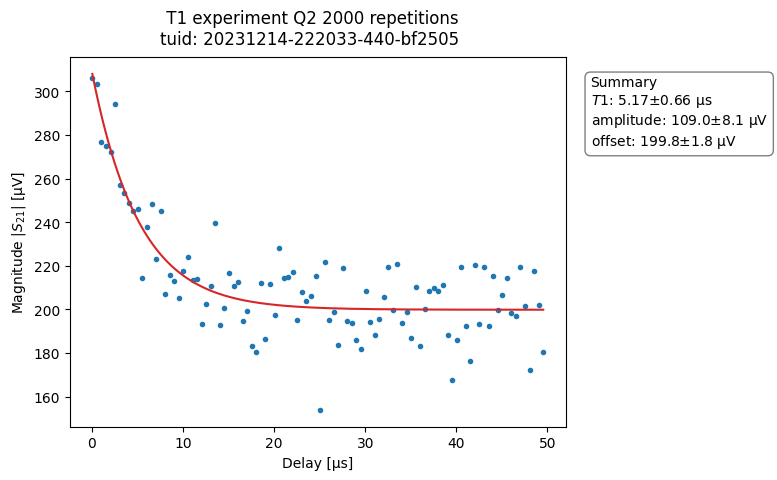

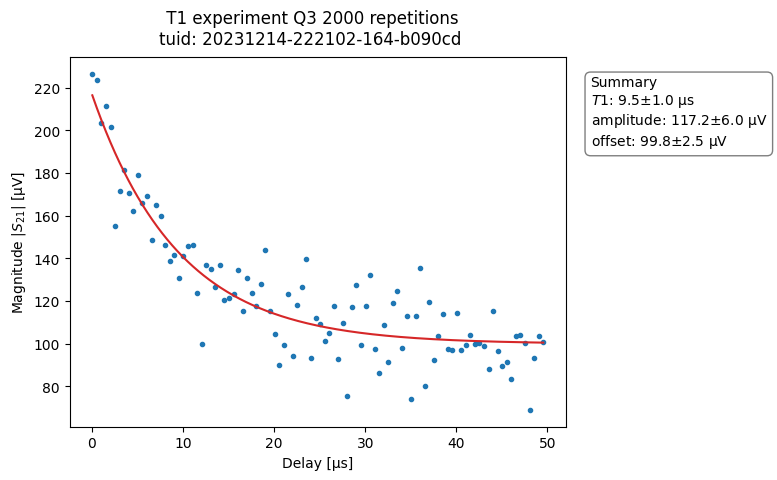

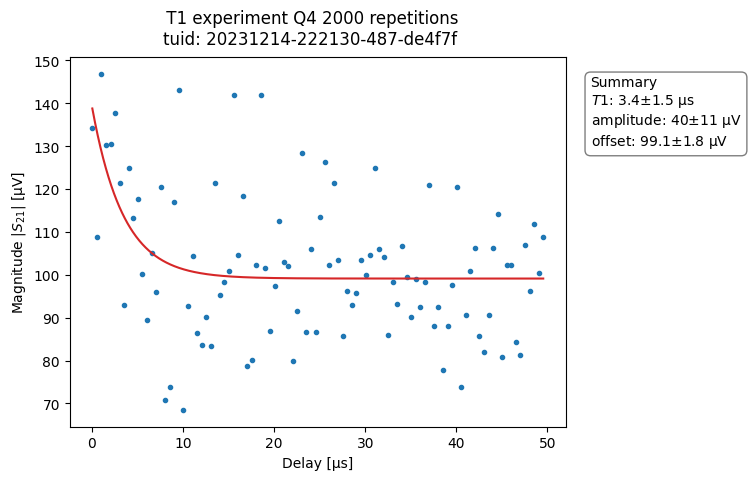

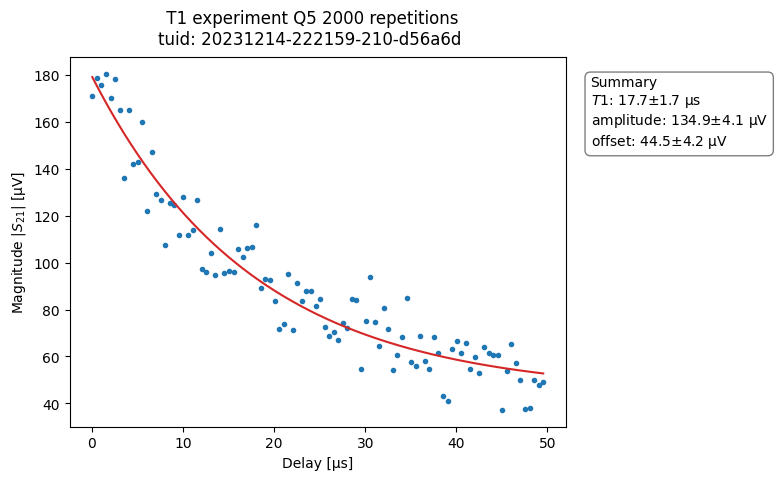

In [117]:
for _, analysis in zip(ordered_elements, t1_analyses):
    analysis.display_figs_mpl()

In [119]:
for k, v in flux_settable_map.items():
    print("flux setpoint", k, v(), v.unit)

flux setpoint Q1 0.0917067527770996 V
flux setpoint Q2 0.125925064086914 V
flux setpoint Q3 0.0928130149841309 V
flux setpoint Q4 0.0928130149841309 V
flux setpoint Q5 0.113107442855835 V


In [118]:
dh.get_latest_tuid() # use this id for qiskit

'20231214-222159-210-d56a6d'